# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages, which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission if necessary. 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

In addition to implementing code, there is a writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) that can be used to guide the writing process. Completing the code template and writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/481/view) for this project.

The [rubric](https://review.udacity.com/#!/rubrics/481/view) contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this Ipython notebook and also discuss the results in the writeup file.


>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [24]:
# Load pickled data
import pickle
import numpy as np

# TODO: Fill this in based on where you saved the training and testing data

training_file = 'dataset/train.p'
validation_file= 'dataset/valid.p'
testing_file = 'dataset/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

In [25]:
from keras.datasets import cifar10
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
# y_train.shape is 2d, (50000, 1). While Keras is smart enough to handle this
# it's a good idea to flatten the array.
y_train = y_train.reshape(-1)
y_test = y_test.reshape(-1)

In [26]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.3, random_state=42, stratify = y_train)

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [27]:
### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results

# TODO: Number of training examples
n_train = X_train.shape[0]

# TODO: Number of validation examples
n_validation = X_valid.shape[0]

# TODO: Number of testing examples.
n_test = X_test.shape[0]

# TODO: What's the shape of an traffic sign image?
image_shape = X_train[1].shape

# TODO: How many unique classes/labels there are in the dataset.
n_classes = np.unique(np.concatenate((y_train, y_valid, y_test))).size

print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 35000
Number of validation examples = 15000
Number of testing examples = 10000
Image data shape = (32, 32, 3)
Number of classes = 10


### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc. 

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections. It can be interesting to look at the distribution of classes in the training, validation and test set. Is the distribution the same? Are there more examples of some classes than others?

### Random set of signs to get a feeling for the data set

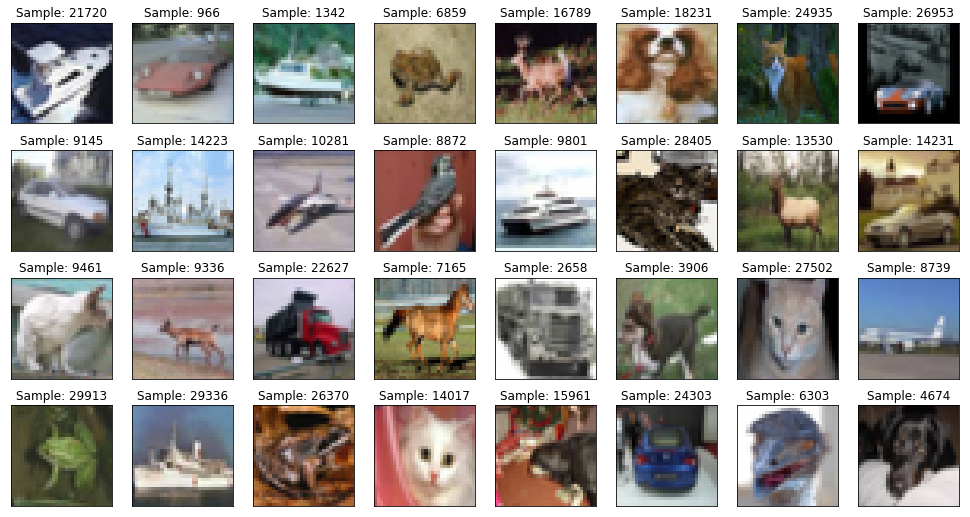

In [28]:
### Data exploration visualization code goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
import random

# Visualizations will be shown in the notebook.
%matplotlib inline

### My Code starts here ###


plt.figure(figsize=(17,9))

for n in range(32):
    index = random.randint(0, len(X_train)-1)
    image = X_train[index]
    plt.subplot(4,8,n+1)
    plt.xticks([]), plt.yticks([])
    plt.imshow(image, cmap="gray")
    plt.title('Sample: ' + str(index))
    
plt.show()

### Examples of some bad samples
During the exploration of the data set I found some samples that are in very low contrast, either dark, bright or dark in front of a bright background. These will be the benchmark for the preprocessing of the images later on.

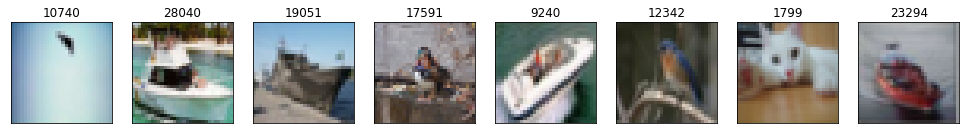

In [29]:
plt.figure(figsize=(17,2))

index_bad = [10740, 28040, 19051, 17591, 9240, 12342, 1799, 23294]


for n in range(len(index_bad)):
    index = index_bad[n]
    image = X_train[index]
    plt.subplot(1,8,n+1)
    plt.xticks([]), plt.yticks([])
    plt.imshow(image, cmap="gray")
    plt.title(index)

plt.show()

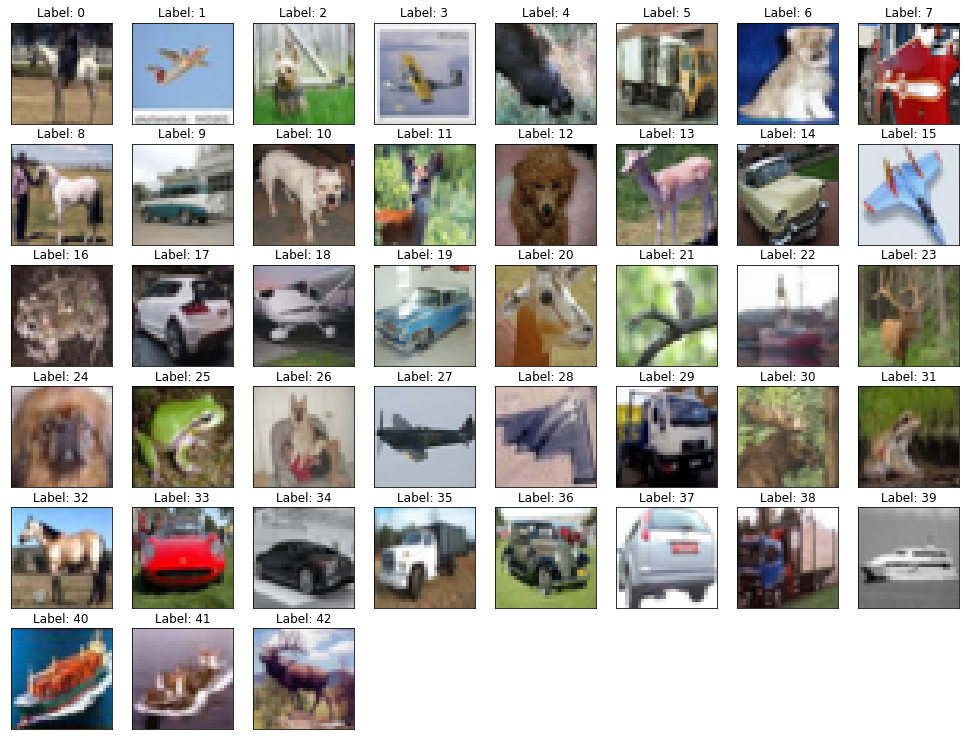

In [30]:
# generate list of one good sample for every label for later use 
def get_prototypes(X_train):
    prototype_index = np.array([9972, 4164, 32034, 6175, 7498, 
                             12826, 21749, 24955, 16466, 11454, 
                             17274, 8958, 28756, 21867, 29693, 
                             30139, 5272, 31146, 21447, 6748,  
                             26183, 25913, 4588, 1934, 10885, 
                             34406, 1577, 10526, 26956, 10578, 
                             25220, 509, 10193, 26747, 20205, 
                             20003, 983, 4907, 14545, 25512, 
                             4220, 171, 9873 ])    

    X_prototypes = np.array([])
    
    for n in prototype_index:
        if X_prototypes.size == 0:
            X_prototypes = X_train[n].reshape(1,32,32,3)
        else:
            X_prototypes = np.vstack((X_prototypes, X_train[n].reshape(1,32,32,3)))
    
    return X_prototypes
    

X_prototypes = get_prototypes(X_train)    

# Print one example for every label.
plt.figure(figsize=(17,13))

for n in range(len(X_prototypes)):
    image = X_prototypes[n]
    plt.subplot(6,8,n+1)
    plt.xticks([]), plt.yticks([])
    plt.imshow(image, cmap="gray")
    plt.title('Label: '+ str(n))

plt.show()

# Histogram of each label in the data

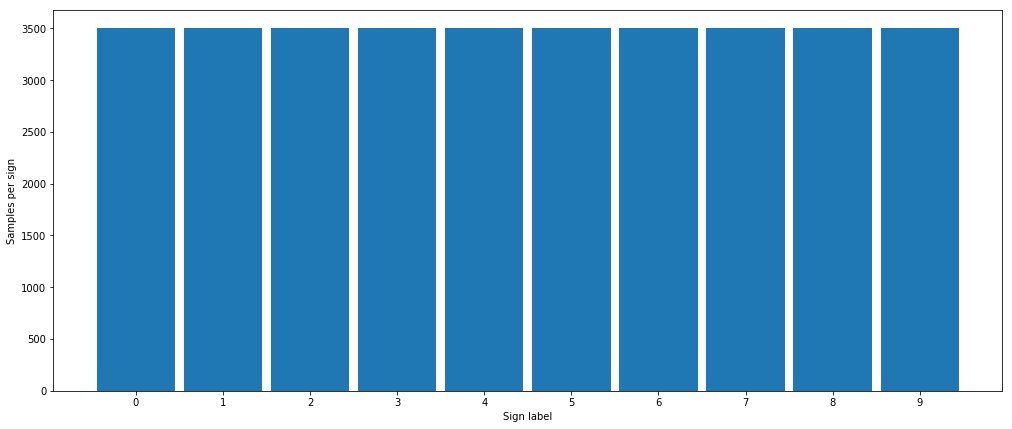

In [31]:
def print_histogram():
    plt.figure(figsize=(17,7))
    plt.hist(y_train, bins=n_classes, rwidth=0.9, range=[0,n_classes], align='left')
    plt.xticks( np.arange(n_classes) )
    #plt.xticks(np.arange(n_classes), np.bincount(y_train))
    plt.xlabel('Sign label')
    plt.ylabel('Samples per sign')
    plt.show()
    return

print_histogram()

### Conclusions after data exploration 
There are possible challenges.
1. Some samples in the data are hard to dicern because they are blurry or are very dark or light. The preprocessing should tackle this.
2. The data is unevenly distributed across the labels. The most common label is 10 times more frequent than the least common. Since we don't know how the test data is distributed, some data augmentation should be used to equate the histogram.

(Note: Its very likely that the test data is similarly distributed, because it came from the same dataset.)

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play! 

With the LeNet-5 solution from the lecture, you should expect a validation set accuracy of about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Pre-process the Data Set (normalization, grayscale, etc.)

Minimally, the image data should be normalized so that the data has mean zero and equal variance. For image data, `(pixel - 128)/ 128` is a quick way to approximately normalize the data and can be used in this project. 

Other pre-processing steps are optional. You can try different techniques to see if it improves performance. 

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

----
For preprocessing there are four steps done.
1. Equalizing the histogram of the images. I experimented with cv2.equalizeHist, skimage.exposure.equalize_hist and skimage.exposure.rescale_intensity. Exposure.equalize_hist yielded the best results.
2. Augment the data by generating similar images by rotating, shifting, blur and noise.
3. Normalize to get a mean of 0 over the data set.
4. Shuffle the data using sklearn

In [32]:
### Preprocess the data here. It is required to normalize the data. Other preprocessing steps could include 
### converting to grayscale, etc.
### Feel free to use as many code cells as needed.
from skimage import exposure, transform, util
import cv2
from sklearn.utils import shuffle
import math

# increase the  by equalizing the histogram
def hist_equ(img):
    img_hist = exposure.equalize_hist(img)
    return img_hist

# normalize to get the values between [-1,1] and the mean to zero. 
def normalize(img):
    x_mean = float(img.mean())
    x_std = float(img.std())
    img_norm = (img - x_mean)/(x_std)
    return img_norm

# grayscale conversion. NOT USED. 
def grayscale(img):
    gray = np.array([])
    for n in range(img.shape[0]):
        img_gray = cv2.cvtColor(img[n], cv2.COLOR_RGB2GRAY)
        if gray.size == 0:
            gray = img_gray.reshape(1,32,32,1)
        else:
            gray = np.vstack((gray, img_gray.reshape(1,32,32,1)))
    return gray


# Data augementation
# 1. Get labels with a samplecount below low_limit.
# 1. choose num_samples random samples per label
# 2. run 8 data augmentation algorithms on these samples and append them to the train dataset.

def augment_data(X_train, y_train, low_limit = 5000 , num_samples = 100):
    from tqdm import tqdm
    
    # get list of labels with a samplecount below low_limit
    label_list = np.where(np.bincount(y_train)<low_limit)
    
    # loop over labels to be augmented
    for label in np.nditer(label_list): 
        index_list = []
        
        # check if number of random samples is below number of total samples to prevent infinite loop
        assert num_samples <= np.bincount(y_train).min()
        
        # Get random indexes of certain label
        while len(index_list)<num_samples:
            index = random.randint(0, len(y_train)-1)
            if label == y_train[index] and not np.any(np.in1d(index_list, index)):
                index_list.append(index)
       
        # Do data augmentation for every sample on index_list
        for m in tqdm(index_list):
            X_train = np.vstack((X_train, blur(X_train[m]).reshape(1,32,32,3)))
            y_train = np.append(y_train, label)
            
            X_train = np.vstack((X_train, noise(X_train[m]).reshape(1,32,32,3)))        
            y_train = np.append(y_train, label)
            
            X_train = np.vstack((X_train, project_left(X_train[m]).reshape(1,32,32,3)))        
            y_train = np.append(y_train, label)
            
            X_train = np.vstack((X_train, project_right(X_train[m]).reshape(1,32,32,3)))        
            y_train = np.append(y_train, label)
            
            X_train = np.vstack((X_train, rotate_left(X_train[m]).reshape(1,32,32,3)))        
            y_train = np.append(y_train, label)
            
            X_train = np.vstack((X_train, rotate_left(X_train[m]).reshape(1,32,32,3)))        
            y_train = np.append(y_train, label)
            
            X_train = np.vstack((X_train, shear_right(X_train[m]).reshape(1,32,32,3)))        
            y_train = np.append(y_train, label)
            
            X_train = np.vstack((X_train, shear_left(X_train[m]).reshape(1,32,32,3)))        
            y_train = np.append(y_train, label)
    
    return X_train, y_train


## Data augmentation methods

def blur(img):
    img_aug = cv2.blur(img, (2,2))
    return img_aug

def noise(img, mode='s&p'):
    img_aug = util.random_noise(img)
    return img_aug

def project_left(img):
    tform = transform.ProjectiveTransform()
    src = np.array([[0, 0], [0, 32], [32, 32], [32, 0]])
    dst = np.array([[0, -15], [0, 47], [32, 32], [32, 0]])
    tform.estimate(src, dst)
    img_aug = transform.warp(img, tform)
    return img_aug

def project_right(img):
    tform = transform.ProjectiveTransform()
    src = np.array([[0, 0], [0, 32], [32, 32], [32, 0]])
    dst = np.array([[0, 0], [0, 32], [32, 47], [32, -15]])
    tform.estimate(src, dst)
    img_aug = transform.warp(img, tform)
    return img_aug

def rotate_right(img):
    tform = transform.AffineTransform(rotation=-0.2, translation = (-5, 5))
    img_aug = transform.warp(img, tform)
    return img_aug 

def rotate_left(img):
    tform = transform.AffineTransform(rotation=0.2, translation = (5, -5))
    img_aug = transform.warp(img, tform)
    return img_aug

def shear_right(img):
    tform = transform.AffineTransform(rotation=0, shear=0.3, translation = (5, 0))
    img_aug = transform.warp(img, tform)
    return img_aug 

def shear_left(img):
    tform = transform.AffineTransform(rotation=0, shear=-0.3, translation = (-5, 0))
    img_aug = transform.warp(img, tform)
    return img_aug 

### Visualisation of proprocessing

#### Histogram equalization

C:\Users\qi10487\AppData\Local\Continuum\Anaconda3\envs\carnd-term1\lib\site-packages\skimage\exposure\exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warn("This might be a color image. The histogram will be "


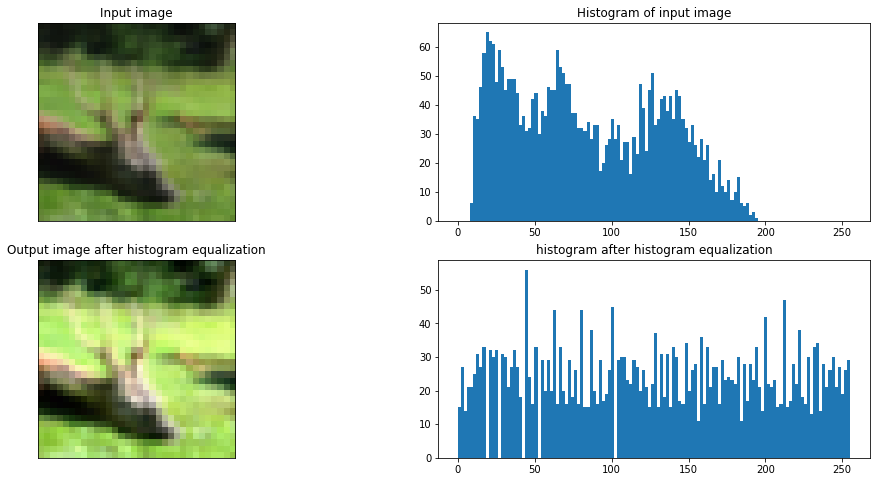

In [33]:
%matplotlib inline

def test_hist_equ(image):
    bins = 128
    plt.figure(figsize=(17,8))
    
    plt.subplot(221)
    plt.xticks([]), plt.yticks([])
    plt.title('Input image')
    plt.imshow(image, cmap="gray")
    plt.subplot(222)
    plt.title('Histogram of input image')
    plt.hist(image.ravel(),bins=bins, range=[0,255], rwidth=2)
    
    image2 = hist_equ(image)
    plt.subplot(223)
    plt.title('Output image after histogram equalization')
    plt.xticks([]), plt.yticks([])
    plt.imshow(image2, cmap="gray")
    plt.subplot(224)
    plt.title('histogram after histogram equalization')
    plt.hist(image2.ravel()*255, bins=bins, range=[0,255], rwidth=2)

    plt.show()
    return

test_hist_equ(X_train[29222])

#### Data augmentation

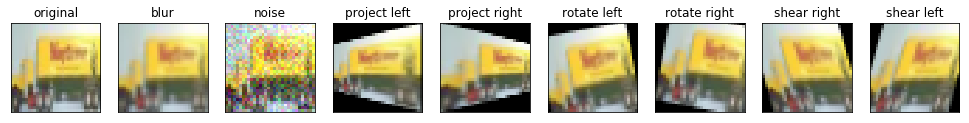

In [34]:
%matplotlib inline
plt.figure(figsize=(17,4))

image = X_train[21443]

plt.subplot(191)
plt.xticks([]), plt.yticks([])
plt.imshow(image, cmap="gray")
plt.title('original')

plt.subplot(192)
plt.xticks([]), plt.yticks([])
plt.imshow(blur(image), cmap="gray")
plt.title('blur')

plt.subplot(193)
plt.xticks([]), plt.yticks([])
plt.imshow(noise(image), cmap="gray") 
plt.title('noise')

plt.subplot(194)
plt.xticks([]), plt.yticks([])
plt.imshow(project_left(image), cmap="gray") 
plt.title('project left')

plt.subplot(195)
plt.xticks([]), plt.yticks([])
plt.imshow(project_right(image), cmap="gray")
plt.title('project right')

plt.subplot(196)
plt.xticks([]), plt.yticks([])
plt.imshow(rotate_left(image), cmap="gray")
plt.title('rotate left')

plt.subplot(197)
plt.xticks([]), plt.yticks([])
plt.imshow(rotate_right(image), cmap="gray")
plt.title('rotate right')

plt.subplot(198)
plt.xticks([]), plt.yticks([])
plt.imshow(shear_right(image), cmap="gray")
plt.title('shear right')

plt.subplot(199)
plt.xticks([]), plt.yticks([])
plt.imshow(shear_left(image), cmap="gray")
plt.title('shear left')

plt.show()

### Do data processing

In [35]:
## Save augmented dataset
def pickle_save(filename, features, labels):
    import pickle
    root = 'dataset/'
    data = {
        'features': features,
        'labels': labels
    }
    pickle.dump(data, open(root + filename, "wb"))
    return

In [11]:
%%time
#Do Data Preprocessing
import os

# Train
X_train = hist_equ(X_train)

print('Size of training dataset prior to augmentation: ',X_train.shape)
if os.path.exists('dataset/train_augmented.p'):
    with open('dataset/train_augmented.p', mode='rb') as f:
        train = pickle.load(f)
    X_train, y_train = train['features'], train['labels']
else:
    X_train, y_train = augment_data(X_train, y_train, num_samples = 100)
    pickle_save('train_augmented.p', X_train, y_train)

print('Size of training dataset prior after augmentation: ',X_train.shape)


print('Size of training dataset prior after grayscale: ',X_train.shape)
X_train = normalize(X_train)
X_train, y_train = shuffle(X_train, y_train)


assert X_train.shape[0] == y_train.shape[0]

# Valid
X_valid = hist_equ(X_valid)

X_valid = normalize(X_valid)


# Test
X_test = hist_equ(X_test)
X_test = normalize(X_test)

Size of training dataset prior to augmentation:  (34799, 32, 32, 3)
Size of training dataset prior after augmentation:  (69199, 32, 32, 3)
Size of training dataset prior after grayscale:  (69199, 32, 32, 3)
Wall time: 15.6 s


In [36]:
X_train = hist_equ(X_train)

print('Size of training dataset prior to augmentation: ',X_train.shape)


print('Size of training dataset prior after augmentation: ',X_train.shape)


print('Size of training dataset prior after grayscale: ',X_train.shape)
X_train = normalize(X_train)
X_train, y_train = shuffle(X_train, y_train)


assert X_train.shape[0] == y_train.shape[0]

# Valid
X_valid = hist_equ(X_valid)

X_valid = normalize(X_valid)


# Test
X_test = hist_equ(X_test)
X_test = normalize(X_test)

Size of training dataset prior to augmentation:  (35000, 32, 32, 3)
Size of training dataset prior after augmentation:  (35000, 32, 32, 3)
Size of training dataset prior after grayscale:  (35000, 32, 32, 3)


### Histogram after data augmentation

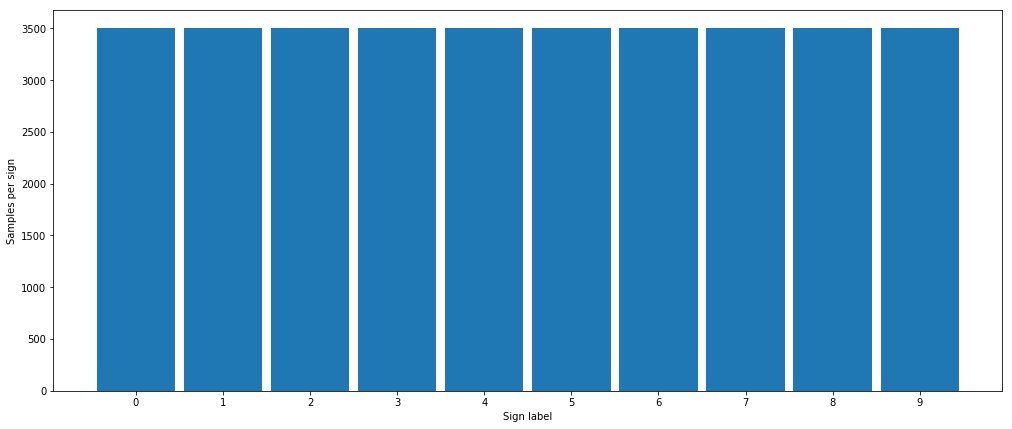

In [37]:
print_histogram()

## Model Architecture 

The architecture looks like this:
0. Input layer: 32x32x3
1. Convulutional layer with kernel 5x5x6. Output is 28x28x6.
2. Convulutional layer with kernel 5x5x6. Output is 24x24x16.
3. Convulutional layer with kernel 5x5x6. Output is 20x20x32.
4. Convulutional layer with kernel 5x5x6. Output is 16x16x50.
5. Flatten. Output is 12800.
6. Fully connected layer with 120 output nodes and a dropout of 0.5 during training.
7. Fully connected layer with 84 output nodes and a dropout of 0.5 during training.
8. Fully connected layer with 43 output nodes used as logits.

In [38]:
### Define your architecture here.
### Feel free to use as many code cells as needed.
import tensorflow as tf
from tensorflow.contrib.layers import flatten

tf.reset_default_graph()

#Hyperparameters
EPOCHS = 10
BATCH_SIZE = 128
rate = 0.001
dropout = 0.5

In [39]:
def CNN(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # Layer 1: Convolutional. Input = 32x32x3. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 3, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b
    conv1 = tf.nn.relu(conv1)
    
    # Layer 2: Convolutional. Output = 24x24x16. 
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    conv2 = tf.nn.relu(conv2)
    
    # Layer 3: Convolutional. Output = 20x20x32. 
    conv3_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 16, 32), mean = mu, stddev = sigma))
    conv3_b = tf.Variable(tf.zeros(32))
    conv3   = tf.nn.conv2d(conv2, conv3_W, strides=[1, 1, 1, 1], padding='VALID') + conv3_b
    conv3 = tf.nn.relu(conv3)
    
    # Layer 4: Convolutional. Output = 16x16x50. 
    conv4_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 32, 50), mean = mu, stddev = sigma))
    conv4_b = tf.Variable(tf.zeros(50))
    conv4   = tf.nn.conv2d(conv3, conv4_W, strides=[1, 1, 1, 1], padding='VALID') + conv4_b
    conv4 = tf.nn.relu(conv4)
     
    # Flatten. Input = 16x16x50 Output = 12800.
    fc1 = flatten(conv4)
    
    # Layer 5: Fully Connected. Input = 12800. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(12800, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc1, fc1_W) + fc1_b
    
    # Activation and Dropout
    fc1 = tf.nn.relu(fc1)
    fc1 = tf.nn.dropout(fc1, keep_prob)
    
    # Layer 6: Fully Connected. Input = 120. Output = 84.
    fc2_W = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b = tf.Variable(tf.zeros(84))
    fc2   = tf.matmul(fc1, fc2_W) + fc2_b
    
    #  Activation and Dropout
    fc2 = tf.nn.relu(fc2)
    fc2 = tf.nn.dropout(fc2, keep_prob)

    # Layer 5: Fully Connected Output Layer. Input = 84. Output = 43.
    fc3_W = tf.Variable(tf.truncated_normal(shape=(84, 10), mean = mu, stddev = sigma))
    fc3_b = tf.Variable(tf.zeros(10))
    logits   = tf.matmul(fc2, fc3_W) + fc3_b
    
    
    return logits

In [40]:
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, n_classes)
keep_prob = tf.placeholder(tf.float32)

In [41]:

logits = CNN(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

In [42]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [43]:
### Train your model here.
### Calculate and report the accuracy on the training and validation set.
### Once a final model architecture is selected, 
### the accuracy on the test set should be calculated and reported as well.
### Feel free to use as many code cells as needed.

In [44]:
%%time

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: dropout})
            
        validation_accuracy = evaluate(X_valid, y_valid)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        train_accuracy = evaluate(X_train, y_train)
        print("Train Accuracy = {:.3f}".format(train_accuracy))
        print() 
    
    saver.save(sess, './lenet')
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.301
Train Accuracy = 0.307

EPOCH 2 ...
Validation Accuracy = 0.414
Train Accuracy = 0.428

EPOCH 3 ...
Validation Accuracy = 0.453
Train Accuracy = 0.476

EPOCH 4 ...
Validation Accuracy = 0.489
Train Accuracy = 0.514

EPOCH 5 ...
Validation Accuracy = 0.528
Train Accuracy = 0.576

EPOCH 6 ...
Validation Accuracy = 0.538
Train Accuracy = 0.600

EPOCH 7 ...
Validation Accuracy = 0.539
Train Accuracy = 0.609

EPOCH 8 ...
Validation Accuracy = 0.557
Train Accuracy = 0.651

EPOCH 9 ...
Validation Accuracy = 0.564
Train Accuracy = 0.684

EPOCH 10 ...
Validation Accuracy = 0.565
Train Accuracy = 0.709

Model saved
Wall time: 1h 4min 52s


In [45]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.563


---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

In [21]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.
import matplotlib.image as mpimg

sdir = 'additional_signs/'
X_test_own = np.array([])

for n in range(8):
    image = mpimg.imread(sdir + str(n+1) + '.jpg')
    if X_test_own.size == 0:
        X_test_own = image.reshape(1,32,32,3)
    else:
        X_test_own = np.vstack((X_test_own, image.reshape(1,32,32,3)))



y_test_own = np.array([36, #Go straight or right
                      24, #Road narrows on the right
                      13, #Yield
                      33, #Turn right ahead
                      17, #No entry
                      11, #Right-of-way at the next intersection
                      12, #Priority road
                      31, #Wild animals crossing
                      ])

assert X_test_own.shape[0] == y_test_own.shape[0]

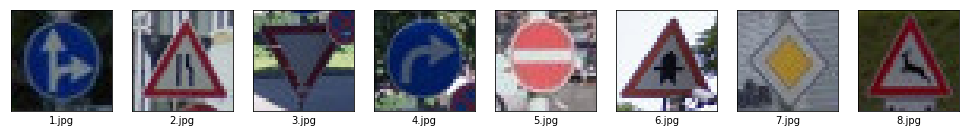

In [22]:
plt.figure(figsize=(17,6))

for n in range(len(y_test_own)):
    image = X_test_own[n]
    plt.subplot(1,len(y_test_own),n+1)
    plt.xticks([]), plt.yticks([])
    plt.imshow(image, cmap="gray")
    plt.xlabel(str(n+1) + '.jpg')

### Predict the Sign Type for Each Image

In [23]:
# Do preprocessing on images'
X_test_copy = X_test_own.copy()
X_test_own = hist_equ(X_test_own)
X_test_own = normalize(X_test_own)

### Analyze Performance

In [24]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test_own, y_test_own)
    print("Accuracy with images from the internet = {:.3f}".format(test_accuracy))

INFO:tensorflow:Restoring parameters from .\lenet
Accuracy with images from the internet = 1.000


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tk.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

INFO:tensorflow:Restoring parameters from .\lenet


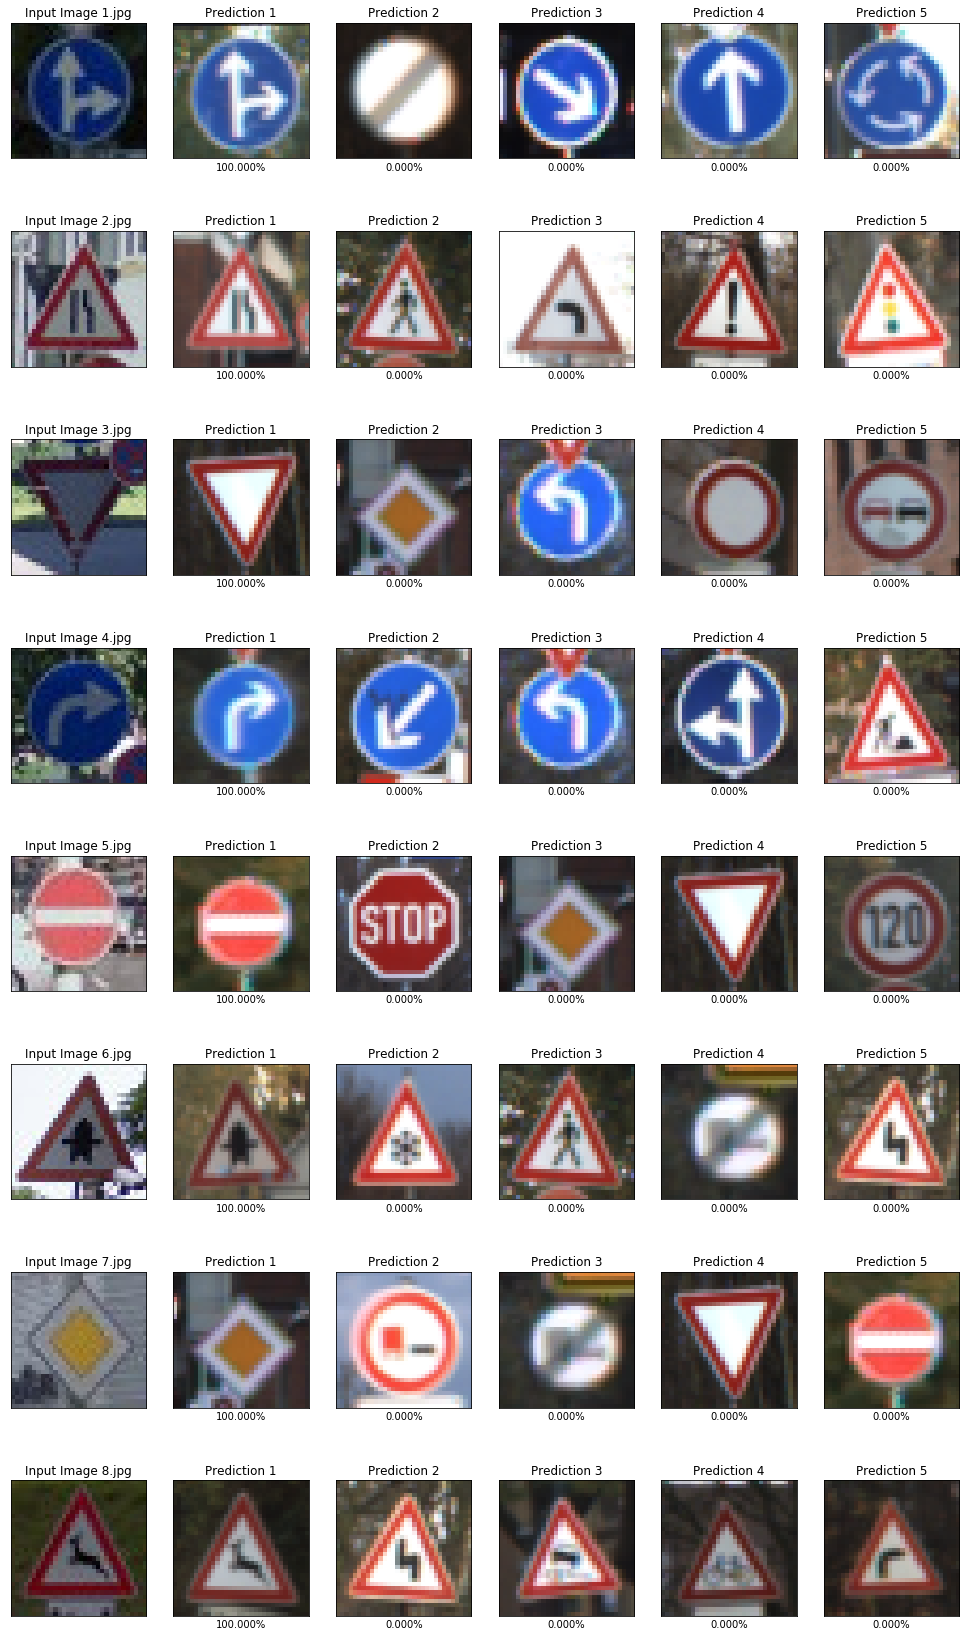

In [25]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.

softmax = tf.nn.softmax(logits)
top_k = tf.nn.top_k(softmax, k =5,sorted=True)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_top_k = sess.run(top_k, feed_dict={x: X_test_own, keep_prob: 1.0})

prob, label = test_top_k

plt.figure(figsize=(17,30))

for n in range(prob.shape[0]):
    image = X_test_copy[n]
    plt.subplot(8,6,n*6+1)
    plt.xticks([]), plt.yticks([])
    plt.imshow(image, cmap="gray")
    plt.title('Input Image '+ str(n+1) + '.jpg')
    for m in range(prob.shape[1]):
        plt.subplot(8,6,n*6+m+2)
        plt.imshow(X_prototypes[label[n,m]], cmap="gray")
        plt.xticks([]), plt.yticks([])
        plt.title('Prediction {}'.format(m+1))
        plt.xlabel('{:2.3f}%'.format(prob[n,m]*100))
    
        
plt.show()


### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 

# Notes:
- Dataset is not high quality. Very dark pictures. Very small pictures. Some I can't even recognise. Put in some examples.


> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [ ]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")